In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Rule Optimiser Example

This notebook contains an example of how the Rule Optimiser module can be used to optimise the thresholds of an existing set of rules, given a labelled dataset.

## Requirements

To run, you'll need the following:
* Install the Rule Optimisation package - see the readme for more information.
* A rule set stored in the standard ARGO lambda expression format, along with the keyword arguments for each lambda expression (more information on how to do this later)
* A labelled dataset containing the features present in the rule set.

----

## Import packages

In [10]:
from rule_optimisation.rule_optimiser import RuleOptimiser
from simility_requests.rule_requests import ReturnRuleConditionsFromSimility, ReturnRuleConfigsFromSimility, CreateRulesInSimility, UpdateRulesInSimility
from rules.rules import Rules
from simility_apis.set_password import set_password
from rule_optimisation.optimisation_functions import FScore
from rule_application.argo_rule_applier import ArgoRuleApplier

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

## Read in data

Firstly, we need to read in the raw data containing the features and the fraud label:

In [11]:
data = pd.read_csv('../../examples/dummy_data/dummy_pipeline_output_data.csv', index_col='eid')

Then we need to split out the dataset into the features (*X*) and the target column (*y*):

In [12]:
fraud_column = 'sim_is_fraud'
X = data.drop(fraud_column, axis=1)
y = data[fraud_column]

Finally, we can split the features and target column into training and test sets:

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

# Rule Optimisation <a name="RuleOptimisation"></a>

Now we can optimise rules which currently reside in the Simility environment. This process involves the following steps:

1. Fetch the system rule conditions from the Simility environment.
2. Convert these conditions into an ARGO-readable format.
3. Optimise the thresholds of these rules.
4. Apply the optimised rules to the dataset.
5. Get the binary columns for the un-optimised rules

## 1. Fetch the rule conditions from the Simility environment

To pull the system rule conditions, we'll use the *return_rule_conditions_from_simility* module in the *simility_requests* sub-package:

In [14]:
set_password()

Please provide your password for logging into the Simility platform:  ·········


In [17]:
rrc = ReturnRuleConditionsFromSimility(url='http://sim-ds.us-central1.gcp.dev.paypalinc.com',
                                       app_prefix='james_testing',
                                       user='james@simility.com',
                                       entity='transaction',
                                       keep_active_only=True)

In [18]:
orig_sys_conditions = rrc.request()

### Outputs

The *.request()* method returns a dictionary of the system rule names (keys) and their conditions (values).

In [19]:
orig_sys_conditions['ComplicatedRule']

{'condition': 'AND',
 'rules': [{'id': 'num_order_items',
   'field': 'num_order_items',
   'type': 'integer',
   'operator': 'greater',
   'value': 'value.5',
   'data': {}},
  {'condition': 'OR',
   'rules': [{'condition': 'AND',
     'rules': [{'id': 'order_total',
       'field': 'order_total',
       'type': 'double',
       'operator': 'greater',
       'value': 'value.1000'},
      {'id': 'is_existing_user',
       'field': 'is_existing_user',
       'type': 'boolean',
       'input': 'radio',
       'operator': 'equal',
       'value': '1'}]},
    {'condition': 'AND',
     'rules': [{'id': 'order_total',
       'field': 'order_total',
       'type': 'double',
       'operator': 'greater',
       'value': 'value.500'},
      {'id': 'is_existing_user',
       'field': 'is_existing_user',
       'type': 'boolean',
       'input': 'radio',
       'operator': 'equal',
       'value': '0'}]},
    {'condition': 'OR',
     'rules': [{'id': 'billing_city',
       'field': 'billing_city'

## 2. Convert rule conditions into an ARGO-readable format

Now that we have the system rule conditions, we need to convert them to an ARGO-readable format. To do this, we'll use the *rules* module - this module allows us to define a set of rules using a given format, then convert this rule set to a difference format. In this case, we'll be converting from the system-ready format to the standard ARGO lambda expression format.

The standard ARGO lambda expression format allows new values to be injected into the condition string of a rule. This means that the rule's performance can be evaluated with new values (which is used in the Rule Optimisation step).

In [20]:
system_rules = Rules(system_dicts=orig_sys_conditions)

In [21]:
system_lambdas = system_rules.as_rule_lambdas(as_numpy=False, with_kwargs=True)

/Users/jlaidler/Documents/tigress/tigress/argo/argo/rules/rules/convert_system_dicts_to_rule_dicts.py:74: UserWarning: JavaEL : Operator `java_el` is not currently supported in ARGO. Rule cannot be parsed.
  warnings.warn(f'{rule_name} : {e}')


In [22]:
system_lambdas

{'RGDT_Rule137': <function rules.convert_rule_dicts_to_rule_strings.ConvertRuleDictsToRuleStrings._convert_to_lambda.<locals>._make_lambda.<locals>.<lambda>(**kwargs)>,
 'CreateRuleTest2': <function rules.convert_rule_dicts_to_rule_strings.ConvertRuleDictsToRuleStrings._convert_to_lambda.<locals>._make_lambda.<locals>.<lambda>(**kwargs)>,
 'RGDT_Rule81': <function rules.convert_rule_dicts_to_rule_strings.ConvertRuleDictsToRuleStrings._convert_to_lambda.<locals>._make_lambda.<locals>.<lambda>(**kwargs)>,
 'HighFraudTxnPerAccountNum': <function rules.convert_rule_dicts_to_rule_strings.ConvertRuleDictsToRuleStrings._convert_to_lambda.<locals>._make_lambda.<locals>.<lambda>(**kwargs)>,
 'RGDT_Rule256': <function rules.convert_rule_dicts_to_rule_strings.ConvertRuleDictsToRuleStrings._convert_to_lambda.<locals>._make_lambda.<locals>.<lambda>(**kwargs)>,
 'RGDT_Rule35': <function rules.convert_rule_dicts_to_rule_strings.ConvertRuleDictsToRuleStrings._convert_to_lambda.<locals>._make_lambda.<l

**Note that there was one rule that could not be converted into the standard ARGO lambda expression format, as it contains an unsupported operator. The list of rule names that could not be converted are stored in the class attribute *unparsed_rules*.**

### Outputs

The *.as_rule_lambdas()* method returns a dictionary of the set of rules defined using the standard ARGO lambda expression format (values) and their names (keys). It also saves this dictionary as the class attribute *rule_lambdas*.

Three useful attributes created by running the *.as_rule_lambdas()* method are:
- lambda_kwargs (dict): For each rule (keys), a dictionary containing the features used in the rule (keys) and the current values (values). **Only populates when .as_rule_lambdas() is used with the keyword argument with_kwargs=True.**
- lambda_args (dict): For each rule (keys), a list containing the current values used in the rule. **Only populates when .as_rule_lambdas() is used with the keyword argument with_kwargs=False.**
- rule_features (dict): For each rule (keys), a list containing the features used in the rule. **Only populates when .as_rule_lambdas() is used with the keyword argument with_kwargs=False.**
- unparsed_rules (list): List of rules which could not be parsed to an ARGO-ready format (due to unsupported operators).

## 3. Run the Rule Optimiser on the rules

Now that we have the system rules stored in the standard ARGO lambda expression format, we can feed these into the Rule Optimiser to optimise their thresholds:

In [23]:
f1 = FScore(beta=1)

In [26]:
system_opt = RuleOptimiser(rule_lambdas=system_rules.rule_lambdas,
                           lambda_kwargs=system_rules.lambda_kwargs,
                           opt_func=f1.fit,
                           n_iter=30)

**Note that for the feature set, we use the original, raw dataset - this is so the rules are applied to the same data as in the Simility system (e.g. if the rule conditions check for nulls, we need to have nulls present in the dataset):**

In [27]:
opt_rule_strings = system_opt.fit(X=X_train,
                                  y=y_train)

100%|██████████| 30/30 [00:00<00:00, 84.37trial/s, best loss: -0.3197586726998492]  


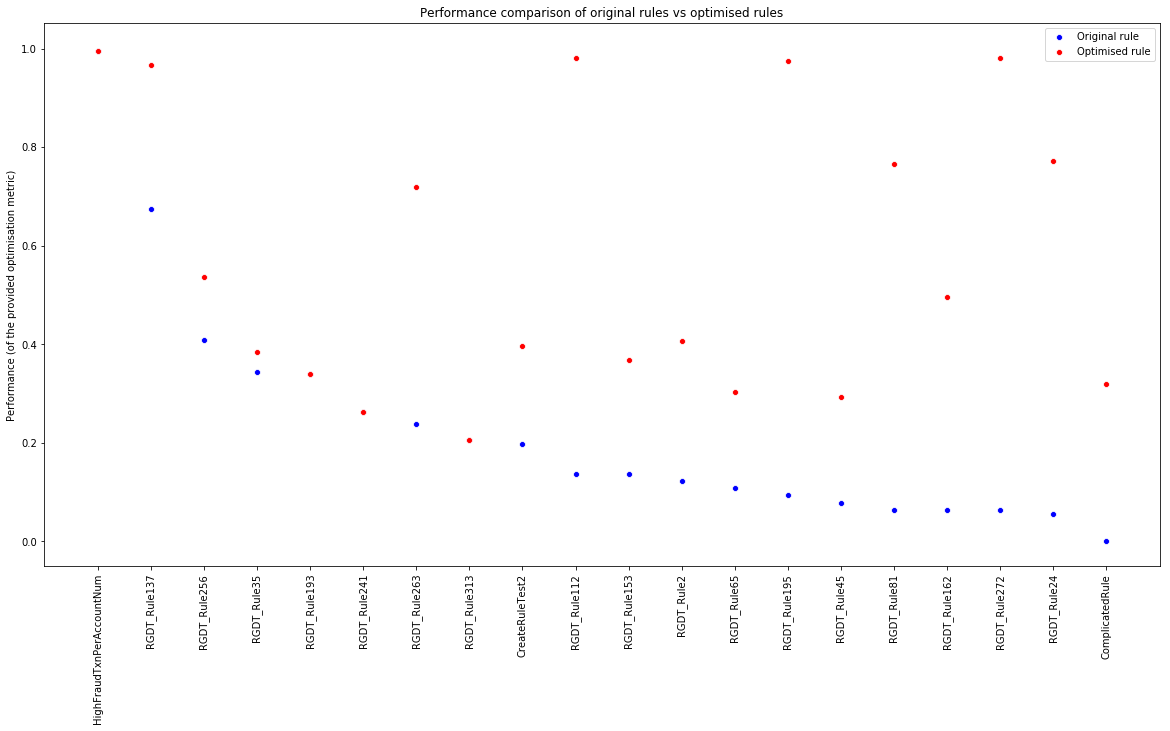

In [28]:
system_opt.plot_performance_uplift(orig_rule_performances=system_opt.orig_rule_performances, 
                                   opt_rule_performances=system_opt.opt_rule_performances)

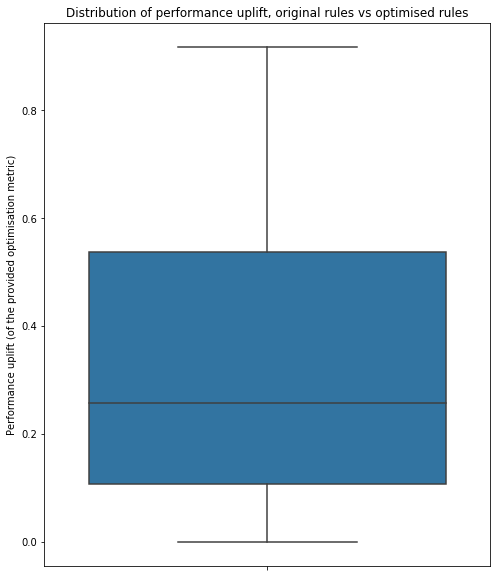

In [29]:
system_opt.plot_performance_uplift_distribution(orig_rule_performances=system_opt.orig_rule_performances, 
                                               opt_rule_performances=system_opt.opt_rule_performances)

## Outputs

The *.fit()* method returns a dictionary of optimised rules stored in the standard ARGO string format (values) and their names (keys)

Useful attributes created by running the *.fit()* method are:
* opt_rule_performances (dict): The optimisation metric (values) calculated for each optimised rule (keys).
* orig_rule_performances (dict): The optimisation metric (values) calculated for each original rule (keys).
* rules (object): Class containing the optimised rules stored in the standard ARGO string format. Methods from this class can be used to convert the rules into the standard ARGO dictionary or lambda expression representations. See the *rules* module for more information.

In [30]:
opt_rule_strings

{'RGDT_Rule137': "((X['account_number_avg_order_total_per_account_number_7day']<=1980.9589551284853)|(X['account_number_avg_order_total_per_account_number_7day'].isna()))&(X['account_number_num_fraud_transactions_per_account_number_1day']>=1)&(X['account_number_num_fraud_transactions_per_account_number_90day']>=1)&((X['account_number_sum_order_total_per_account_number_1day']<=1428.4957963964864)|(X['account_number_sum_order_total_per_account_number_1day'].isna()))",
 'CreateRuleTest2': "(X['order_total']>=621.0956418583902)",
 'RGDT_Rule81': "(X['account_number_avg_order_total_per_account_number_1day']>180.4121799788064)&(X['account_number_num_fraud_transactions_per_account_number_lifetime']>=1)&((X['account_number_num_order_items_per_account_number_30day']<=13)|(X['account_number_num_order_items_per_account_number_30day'].isna()))&((X['account_number_sum_order_total_per_account_number_1day']<=2256.132531934174)|(X['account_number_sum_order_total_per_account_number_1day'].isna()))",
 '

----

# Apply rules to a separate dataset

Use the *.apply()* method to apply the optimised rules to a separate dataset:

In [31]:
X_rules_applied = system_opt.apply(X=X_test, y=y_test, sample_weight=None)

## Outputs

The *.apply()* method returns a dataframe giving the binary columns of the rules as applied to the given dataset.

A useful attribute created by running the *.apply()* method is:
* rule_descriptions: A dataframe showing the logic of the optimised rules and their performance metrics as applied to the given dataset.

In [32]:
system_opt.rule_descriptions.head()

,Precision,Recall,PercDataFlagged,OptMetric,Logic,nConditions
Rule,,,,,,
HighFraudTxnPerAccountNum,0.991304,1.000000,0.026244,0.995633,(X['account_number_num_fraud_transactions_per_...,1
RGDT_Rule112,0.965812,0.991228,0.026700,0.978355,(X['account_number_num_distinct_transaction_pe...,5
RGDT_Rule272,0.965812,0.991228,0.026700,0.978355,((X['account_number_avg_order_total_per_accoun...,5
RGDT_Rule195,0.957627,0.991228,0.026928,0.974138,(X['account_number_num_fraud_transactions_per_...,4
RGDT_Rule137,0.990909,0.956140,0.025103,0.973214,((X['account_number_avg_order_total_per_accoun...,6


In [33]:
opt_rule_performances_test = system_opt.rule_descriptions['OptMetric'].to_dict()

## Apply original rule strings

In [34]:
orig_system_rule_strings = system_rules.as_rule_strings(as_numpy=False)

/Users/jlaidler/Documents/tigress/tigress/argo/argo/rules/rules/convert_system_dicts_to_rule_dicts.py:74: UserWarning: JavaEL : Operator `java_el` is not currently supported in ARGO. Rule cannot be parsed.
  warnings.warn(f'{rule_name} : {e}')


In [35]:
ara = ArgoRuleApplier(rule_strings=orig_system_rule_strings, opt_func=f1.fit)

In [36]:
X_rules_orig_applied = ara.apply(X=X_test, y=y_test)

In [37]:
orig_rule_performances_test = ara.rule_descriptions['OptMetric'].to_dict()

## Plot performance uplift of rules (on test set)

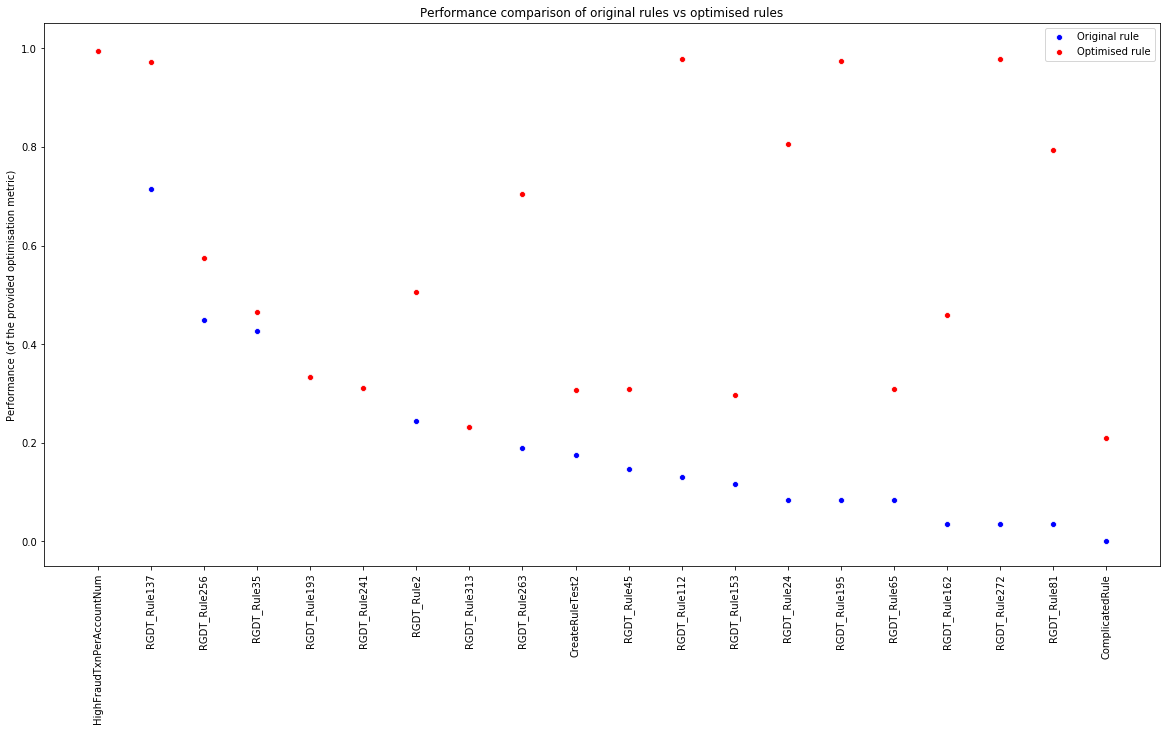

In [38]:
system_opt.plot_performance_uplift(orig_rule_performances=orig_rule_performances_test,
                                   opt_rule_performances=opt_rule_performances_test)

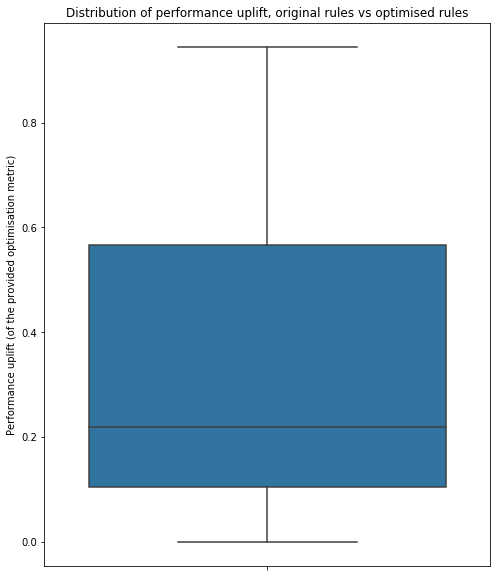

In [39]:
system_opt.plot_performance_uplift_distribution(orig_rule_performances=orig_rule_performances_test,
                                                opt_rule_performances=opt_rule_performances_test)

----

# The End

That's it folks - if you have any queries or suggestions please put them in the *#sim-datatools-help* Slack channel or email James directly.